В цьому домашньому завданні ми знову працюємо з даними з нашого змагання ["Bank Customer Churn Prediction (DLU Course)"](https://www.kaggle.com/t/7c080c5d8ec64364a93cf4e8f880b6a0).

Тут ми побудуємо рішення задачі класифікації з використанням алгоритмів бустингу: XGBoost та LightGBM, а також використаємо бібліотеку HyperOpt для оптимізації гіперпараметрів.

0. Зчитайте дані `train.csv` в змінну `raw_df` та скористайтесь наведеним кодом нижче аби розділити дані на трнувальні та валідаційні і розділити дані на ознаки з матириці Х та цільову змінну. Назви змінних `train_inputs, train_targets, train_inputs, train_targets` можна змінити на ті, які Вам зручно.

  Наведений скрипт - частина отриманого мною скрипта для обробки даних. Ми тут не викнуємо масштабування та обробку категоріальних змінних, бо хочемо це делегувати алгоритмам, які будемо використовувати. Якщо щось не розумієте в наведених скриптах, рекомендую розібратись: навичка читати код - важлива складова роботи в машинному навчанні.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from typing import Tuple, Dict, Any


def split_train_val(df: pd.DataFrame, target_col: str, test_size: float = 0.2, random_state: int = 42) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Split the dataframe into training and validation sets.

    Args:
        df (pd.DataFrame): The raw dataframe.
        target_col (str): The target column for stratification.
        test_size (float): The proportion of the dataset to include in the validation split.
        random_state (int): Random state for reproducibility.

    Returns:
        Tuple[pd.DataFrame, pd.DataFrame]: Training and validation dataframes.
    """
    train_df, val_df = train_test_split(df, test_size=test_size, random_state=random_state, stratify=df[target_col])
    return train_df, val_df


def separate_inputs_targets(df: pd.DataFrame, input_cols: list, target_col: str) -> Tuple[pd.DataFrame, pd.Series]:
    """
    Separate inputs and targets from the dataframe.

    Args:
        df (pd.DataFrame): The dataframe.
        input_cols (list): List of input columns.
        target_col (str): Target column.

    Returns:
        Tuple[pd.DataFrame, pd.Series]: DataFrame of inputs and Series of targets.
    """
    inputs = df[input_cols].copy()
    targets = df[target_col].copy()
    return inputs, targets

In [2]:
raw_df = pd.read_csv('kaggle/train.csv')

In [3]:
input_cols = raw_df.columns[:-1]
target_col = 'Exited'

train_df, val_df = split_train_val(raw_df, 'Exited')

train_inputs, train_targets = separate_inputs_targets(train_df, input_cols=input_cols, target_col=target_col)
val_inputs, val_targets = separate_inputs_targets(val_df, input_cols=input_cols, target_col=target_col)

1. В тренувальному та валідаційному наборі перетворіть категоріальні ознаки на тип `category`. Можна це зробити двома способами:
 1. `df[col_name].astype('category')`, як було продемонстровано в лекції
 2. використовуючи метод `pd.Categorical(df[col_name])`

In [4]:
categorical_columns = train_df.select_dtypes('object').columns

train_inputs[categorical_columns] = train_inputs[categorical_columns].astype('category')
val_inputs[categorical_columns] = val_inputs[categorical_columns].astype('category')

In [5]:
train_df.dtypes

id                   int64
CustomerId         float64
Surname             object
CreditScore        float64
Geography           object
Gender              object
Age                float64
Tenure             float64
Balance            float64
NumOfProducts      float64
HasCrCard          float64
IsActiveMember     float64
EstimatedSalary    float64
Exited             float64
dtype: object

2. Навчіть на отриманих даних модель `XGBoostClassifier`. Параметри алгоритму встановіть на свій розсуд, ми далі будемо їх тюнити. Рекомендую тренувати не дуже складну модель.

  Опис всіх конфігураційних параметрів XGBoostClassifier - тут https://xgboost.readthedocs.io/en/stable/parameter.html#global-config

  **Важливо:** зробіть такі налаштування `XGBoostClassifier` аби він самостійно обробляв незаповнені значення в даних і обробляв категоріальні колонки.

  Можна також, якщо працюєте в Google Colab, увімкнути можливість використання GPU (`Runtime -> Change runtime type -> T4 GPU`) і встановити параметр `device='cuda'` в `XGBoostClassifier` для пришвидшення тренування бустинг моделі.
  
  Після тренування моделі
  1. Виміряйте точність з допомогою AUROC на тренувальному та валідаційному наборах.
  2. Зробіть висновок про отриману модель: вона хороша/погана, чи є high bias/high variance?
  3. Порівняйте якість цієї моделі з тою, що ви отрмали з використанням DecisionTrees раніше. Чи вийшло покращити якість?

In [6]:
from xgboost import XGBClassifier
from process_bank_churn import plot_roc_curve

xgb_cls = XGBClassifier(
    max_depth=5,
    n_estimators=70,
    min_child_weight=2,
    num_parallel_tree=2,
    enable_categorical=True,  # обробка категоріальних колонок
    missing=np.nan,           # заповнення пропущених
    verbosity=2,
    eval_metric='aucpr'
)

Area under ROC score on Train dataset: 91.34334643%


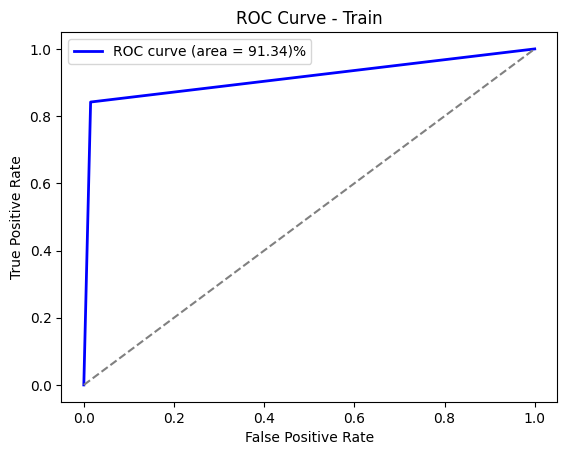

None
Area under ROC score on Validation dataset: 82.58899787%


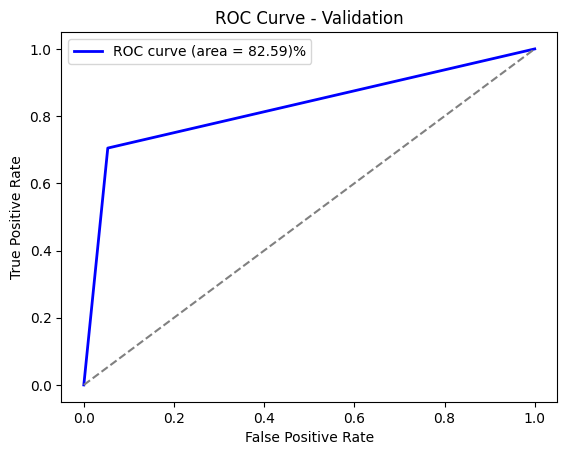

None


In [7]:
xgb_cls.fit(train_inputs, train_targets)

train_pred = xgb_cls.predict(train_inputs)
val_pred = xgb_cls.predict(val_inputs)

print(plot_roc_curve(train_targets, train_pred, 'Train'))
print(plot_roc_curve(val_targets, val_pred, 'Validation'))

На даному етапі не вдалося покращити модель, проте це лише перша ітерація перед тюнингом параметрів. В моделі high variance, вона погано передбачає валідаціний набір. Модель DecisionTree на даному етапі є кращою.

3. Використовуючи бібліотеку `Hyperopt` і приклад пошуку гіперпараметрів для `XGBoostClassifier` з лекції знайдіть оптимальні значення гіперпараметрів `XGBoostClassifier` для нашої задачі. Задайте свою сітку гіперпараметрів виходячи з тих параметрів, які ви б хотіли перебрати. Поставте кількість раундів в підборі гіперпараметрів рівну **20**.

  **Увага!** Для того, аби скористатись hyperopt, нам треба задати функцію `objective`. В ній ми маємо задати loss - це може будь-яка метрика, але бажано використовувтаи ту, яка цільова в вашій задачі. Чим менший лосс - тим ліпша модель на думку hyperopt. Тож, тут нам треба задати loss - негативне значення AUROC. В лекції ми натомість використовували Accuracy.

  Після успішного завершення пошуку оптимальних гіперпараметрів
    - виведіть найкращі значення гіперпараметрів
    - створіть в окремій зміній `final_clf` модель `XGBoostClassifier` з найкращими гіперпараметрами
    - навчіть модель `final_clf`
    - оцініть якість моделі `final_clf` на тренувальній і валідаційній вибірках з допомогою AUROC.
    - зробіть висновок про якість моделі. Чи стала вона краще порівняно з попереднім пунктом (2) цього завдання?

In [8]:
!pip install hyperopt

Defaulting to user installation because normal site-packages is not writeable


In [9]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.metrics import auc, roc_curve

In [10]:
def objective(params):
    clf = XGBClassifier(
    n_estimators=int(params['n_estimators']),
        learning_rate=params['learning_rate'],
        max_depth=int(params['max_depth']),
        min_child_weight=params['min_child_weight'],  # Мінімальна сума ваг всіх вибірок, необхідна в кінцевому вузлі
        subsample=params['subsample'],  # Частка вибірок, що використовуються для побудови кожного дерева
        colsample_bytree=params['colsample_bytree'],  # Частка ознак, що використовуються при побудові кожного дерева
        gamma=params['gamma'],  # Мінімальне зменшення втрат, необхідне для виконання поділу
        reg_alpha=params['reg_alpha'],  # Параметр регуляризації L1 (Lasso)
        reg_lambda=params['reg_lambda'],  # Параметр регуляризації L2 (Ridge)
        enable_categorical=True,
        missing=np.nan,
        early_stopping_rounds=10
    )

    clf.fit(
        train_inputs,
        train_targets,
        eval_set=[(val_inputs, val_targets)],
        verbose=False)
    pred = clf.predict(val_inputs)
    fpr, tpr, _ = roc_curve(val_targets, pred, pos_label=1)
    roc_auc = auc(fpr, tpr)

    return {'loss': -roc_auc, 'status': STATUS_OK}

In [11]:
# Простір гіперпараметрів
space = {
    'n_estimators': hp.quniform('n_estimators', 50, 500, 10),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
    'max_depth': hp.quniform('max_depth', 3, 15, 1),
    'min_child_weight': hp.quniform('min_child_weight', 1, 20, 1),
    'subsample': hp.uniform('subsample', 0.5, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
    'gamma': hp.uniform('gamma', 0, 0.4),
    'reg_alpha': hp.uniform('reg_alpha', 0, 1),
    'reg_lambda': hp.uniform('reg_lambda', 0, 1)
}

# Оптимізація
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=10, trials=trials)


00%|██████| 10/10 [00:02<00:00,  4.31trial/s, best loss: -0.8206221277179504]

In [12]:
# Перетворення значень гіперпараметрів у кінцеві типи
best['n_estimators'] = int(best['n_estimators'])
best['max_depth'] = int(best['max_depth'])
best['min_child_weight'] = int(best['min_child_weight'])

print("Найкращі гіперпараметри: ", best)

# Навчання фінальної моделі з найкращими гіперпараметрами
final_clf = XGBClassifier(
    n_estimators=best['n_estimators'],
    learning_rate=best['learning_rate'],
    max_depth=best['max_depth'],
    min_child_weight=best['min_child_weight'],
    subsample=best['subsample'],
    colsample_bytree=best['colsample_bytree'],
    gamma=best['gamma'],
    reg_alpha=best['reg_alpha'],
    reg_lambda=best['reg_lambda'],
    enable_categorical=True,
    missing=np.nan
)

final_clf.fit(train_inputs, train_targets)
final_pred = final_clf.predict(val_inputs)
fpr, tpr, _ = roc_curve(val_targets, final_pred, pos_label=1)
final_roc_auc = auc(fpr, tpr)
print("AUROC на валідаційній вибірці: {:.6f}".format(final_roc_auc))

Найкращі гіперпараметри:  {'colsample_bytree': 0.9463093053283667, 'gamma': 0.05462515575845735, 'learning_rate': 0.18547068018332277, 'max_depth': 4, 'min_child_weight': 19, 'n_estimators': 100, 'reg_alpha': 0.14228662539708192, 'reg_lambda': 0.8974710867760246, 'subsample': 0.6809543954539022}
AUROC на валідаційній вибірці: 0.815879


4. Навчіть на наших даних модель LightGBM. Параметри алгоритму встановіть на свій розсуд, ми далі будемо їх тюнити. Рекомендую тренувати не дуже складну модель.

  Опис всіх конфігураційних параметрів LightGBM - тут https://lightgbm.readthedocs.io/en/latest/Parameters.html

  **Важливо:** зробіть такі налаштування LightGBM аби він самостійно обробляв незаповнені значення в даних і обробляв категоріальні колонки.

  Аби передати категоріальні колонки в LightGBM - необхідно виявити їх індекси і передати в параметрі `cat_feature=cat_feature_indexes`

  Після тренування моделі
  1. Виміряйте точність з допомогою AUROC на тренувальному та валідаційному наборах.
  2. Зробіть висновок про отриману модель: вона хороша/погана, чи є high bias/high variance?
  3. Порівняйте якість цієї моделі з тою, що ви отрмали з використанням XGBoostClassifier раніше. Чи вийшло покращити якість?

In [13]:
!pip install lightgbm

Defaulting to user installation because normal site-packages is not writeable


In [14]:
cat_feature_indexes = [train_inputs.columns.get_loc(col) for col in categorical_columns]

In [15]:
import lightgbm
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(
    max_depth=7,
    objective='binary',
    n_estimators=50,
    num_trees=50,
    learning_rate=0.1,
    cat_feature=cat_feature_indexes,  # категоріальні ознаки
    missing=np.nan  # пропущені значення
)

[LightGBM] [Warning] Unknown parameter: missing
[LightGBM] [Warning] num_iterations is set=50, num_trees=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Unknown parameter: missing
[LightGBM] [Warning] categorical_feature is set with cat_feature=2,4,5, categorical_column=2,4,5 will be ignored. Current value: categorical_feature=2,4,5
[LightGBM] [Info] Number of positive: 2442, number of negative: 9558
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001454 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1826
[LightGBM] [Info] Number of data points in the train set: 12000, number of used

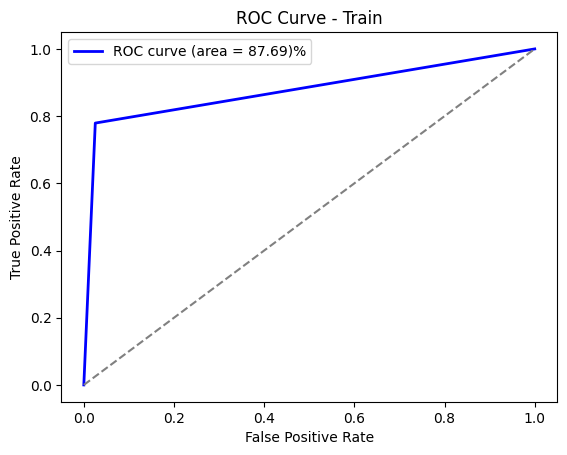

None
Area under ROC score on Validation dataset: 80.92873311%


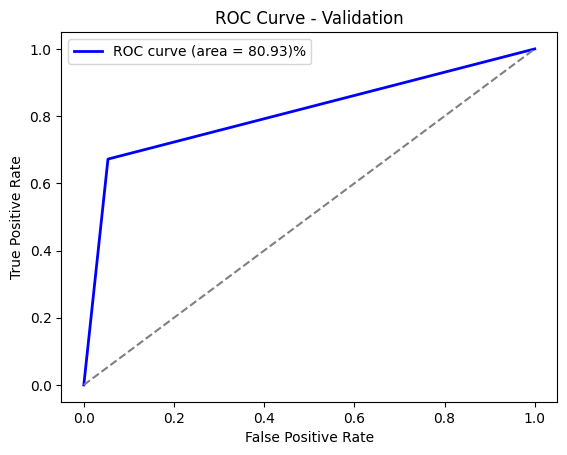

None


In [16]:
lgbm_clf.fit(train_inputs, train_targets, eval_set=[(val_inputs, val_targets)])

train_pred = lgbm_clf.predict(train_inputs)
val_pred = lgbm_clf.predict(val_inputs)

print(plot_roc_curve(train_targets, train_pred, 'Train'))
print(plot_roc_curve(val_targets, val_pred, 'Validation'))

5. Використовуючи бібліотеку `Hyperopt` і приклад пошуку гіперпараметрів для `LightGBM` з лекції знайдіть оптимальні значення гіперпараметрів `LightGBM` для нашої задачі. Задайте свою сітку гіперпараметрів виходячи з тих параметрів, які ви б хотіли перебрати. Поставте кількість раундів в підборі гіперпараметрів рівну **10**.

  **Увага!** Для того, аби скористатись hyperopt, нам треба задати функцію `objective`. І тут ми також ставимо loss - негативне значення AUROC, як і при пошуці гіперпараметрів для XGBoost. До речі, можна спробувати написати код так, аби в objective передавати лише модель і не писати схожий код двічі :)

  Після успішного завершення пошуку оптимальних гіперпараметрів
    - виведіть найкращі значення гіперпараметрів
    - створіть в окремій зміній `final_lgb_clf` модель `LightGBM` з найкращими гіперпараметрами
    - навчіть модель `final_lgb_clf`
    - оцініть якість моделі `final_lgb_clf` на тренувальній і валідаційній вибірках з допомогою AUROC.
    - зробіть висновок про якість моделі. Чи стала вона краще порівняно з попереднім пунктом (4) цього завдання?

In [17]:
def objective(params):
    clf = LGBMClassifier(
        n_estimators=int(params['n_estimators']),  # Кількість дерев у ансамблі (кількість ітерацій бустингу)
        learning_rate=params['learning_rate'],  # Коефіцієнт, на який зменшується внесок кожного доданого дерева
        max_depth=int(params['max_depth']),  # Максимальна глибина кожного дерева
        num_leaves=int(params['num_leaves']),  # Максимальна кількість листків, що дозволяємо кожному дереву мати.
        min_child_weight=params['min_child_weight'],  # Мінімальна сума ваг всіх вибірок, необхідна в кінцевому вузлі
        subsample=params['subsample'],  # Частка вибірок, що використовуються для побудови кожного дерева
        colsample_bytree=params['colsample_bytree'],  # Частка ознак, що використовуються при побудові кожного дерева
        reg_alpha=params['reg_alpha'],  # Параметр регуляризації L1 (Lasso)
        reg_lambda=params['reg_lambda'],  # Параметр регуляризації L2 (Ridge)
        min_split_gain=params['min_split_gain'],  # Мінімальне зменшення втрат, необхідне для виконання поділу
        cat_feature=cat_feature_indexes  # Індекси категорійних ознак
    )

    clf.fit(train_inputs, train_targets, eval_set=[(val_inputs, val_targets)])
    pred = clf.predict(val_inputs)
    fpr, tpr, _ = roc_curve(val_targets, pred, pos_label=1)
    roc_auc = auc(fpr, tpr)

    return {'loss': -roc_auc, 'status': STATUS_OK}

In [18]:
# Простір гіперпараметрів
space = {
    'n_estimators': hp.quniform('n_estimators', 50, 500, 25),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
    'max_depth': hp.quniform('max_depth', 3, 15, 1),
    'num_leaves': hp.quniform('num_leaves', 20, 150, 1),
    'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
    'subsample': hp.uniform('subsample', 0.5, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
    'reg_alpha': hp.uniform('reg_alpha', 0, 1),
    'reg_lambda': hp.uniform('reg_lambda', 0, 1),
    'min_split_gain': hp.uniform('min_split_gain', 0, 0.1)  # додано мінімальне зменшення втрат для поділу
}

# Оптимізація
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=10, trials=trials)

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] categorical_feature is set with cat_feature=2,4,5, categorical_column=2,4,5 will be ignored. Current value: categorical_feature=2,4,5
[LightGBM] [Info] Number of positive: 2442, number of negative: 9558          
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001135 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1826                                             
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.203500 -> initscore=-1.364561
[LightGBM] [Info] Start training from score -1.364561    

In [19]:
# Перетворення значень гіперпараметрів у кінцеві типи
best['n_estimators'] = int(best['n_estimators'])
best['max_depth'] = int(best['max_depth'])
best['num_leaves'] = int(best['num_leaves'])
best['min_child_weight'] = int(best['min_child_weight'])

print("Найкращі гіперпараметри: ", best)

# Навчання фінальної моделі з найкращими гіперпараметрами
final_clf = LGBMClassifier(
    n_estimators=best['n_estimators'],
    learning_rate=best['learning_rate'],
    max_depth=best['max_depth'],
    num_leaves=best['num_leaves'],
    min_child_weight=best['min_child_weight'],
    subsample=best['subsample'],
    colsample_bytree=best['colsample_bytree'],
    reg_alpha=best['reg_alpha'],
    reg_lambda=best['reg_lambda'],
    min_split_gain=best['min_split_gain'],
    cat_feature=cat_feature_indexes,
    missing=np.nan
)

final_clf.fit(train_inputs, train_targets, eval_set=[(val_inputs, val_targets)])
final_pred = final_clf.predict(val_inputs)
fpr, tpr, _ = roc_curve(val_targets, final_pred, pos_label=1)
final_roc_auc = auc(fpr, tpr)

print("AUROC на валідаційній вибірці: {:.6f}".format(final_roc_auc))

Найкращі гіперпараметри:  {'colsample_bytree': 0.8415371677582594, 'learning_rate': 0.13212433049941988, 'max_depth': 7, 'min_child_weight': 6, 'min_split_gain': 0.0663127548768994, 'n_estimators': 350, 'num_leaves': 106, 'reg_alpha': 0.43449826691120796, 'reg_lambda': 0.1677248789095318, 'subsample': 0.51565789149962}
[LightGBM] [Warning] Unknown parameter: missing
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Unknown parameter: missing
[LightGBM] [Warning] categorical_feature is set with cat_feature=2,4,5, categorical_column=2,4,5 will be ignored. Current value: categorical_feature=2,4,5
[LightGBM] [Info] Number of positive: 2442, number of negative: 9558
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000666 seconds.
You can set `force_row_w

В результаті тюнінгу параметрів, XGBClassifier показав себе краще, AUROC вища, аніж в LGBClassifier. Спробуємо застосувати найкращу модель XGBClassifier на даних, для Kaggle

6. Оберіть модель з експериментів в цьому ДЗ і зробіть новий `submission` на Kaggle та додайте код для цього і скріншот скора на публічному лідерборді.
  
  **Напишіть коментар, чому ви обрали саме цю модель?**

  І я вас вітаю - це останнє завдання з цим набором даних 💪 На цьому етапі корисно проаналізувати, які моделі показали себе найкраще і подумати, чому.

In [20]:
from process_bank_churn import preprocess_new_data, preprocess_data, plot_roc_curve
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix

In [21]:
raw_df = pd.read_csv('./kaggle/train.csv')
raw_new_df = pd.read_csv('./kaggle/test.csv')

info = preprocess_data(raw_df)

X_train = info.get("X_train")
y_train = info.get("y_train")
X_val = info.get("X_val")
y_val = info.get("y_val")

X_test = preprocess_new_data(raw_new_df,  info.get('woe_geography'), info.get('scaler'), info.get('encoder'))

/Users/bilukhan/ML course/Practice/process_bank_churn.py:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_inputs[numeric_cols] = scaler.fit_transform(train_inputs[numeric_cols])
/Users/bilukhan/ML course/Practice/process_bank_churn.py:102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_inputs[numeric_cols] = scaler.transform(val_inputs[numeric_cols])


In [22]:
def objective(params):
    clf = XGBClassifier(
    n_estimators=int(params['n_estimators']),
    learning_rate=params['learning_rate'],
    max_depth=int(params['max_depth']),
    min_child_weight=params['min_child_weight'],  # Мінімальна сума ваг всіх вибірок, необхідна в кінцевому вузлі
    subsample=params['subsample'],  # Частка вибірок, що використовуються для побудови кожного дерева
    colsample_bytree=params['colsample_bytree'],  # Частка ознак, що використовуються при побудові кожного дерева
    gamma=params['gamma'],  # Мінімальне зменшення втрат, необхідне для виконання поділу
    reg_alpha=params['reg_alpha'],  # Параметр регуляризації L1 (Lasso)
    reg_lambda=params['reg_lambda'],  # Параметр регуляризації L2 (Ridge)
    enable_categorical=True,
    eval_metric='auc',
    scale_pos_weight=params['scale_pos_weight'],
    missing=np.nan,
    early_stopping_rounds=10
    )

    clf.fit(
        X_train,
        y_train,
        eval_set=[(X_val, y_val)],
        verbose=False)
    pred = clf.predict(X_val)
    fpr, tpr, _ = roc_curve(y_val, pred, pos_label=1)
    roc_auc = auc(fpr, tpr)

    return {'loss': -roc_auc, 'status': STATUS_OK}

In [23]:
space = {
    'n_estimators': hp.quniform('n_estimators', 200, 550, 25),  # Можна зменшити
    'learning_rate': hp.uniform('learning_rate', 0.001, 0.05),  # Можна зменшити
    'max_depth': hp.quniform('max_depth', 3, 4, 1),
    'min_child_weight': hp.quniform('min_child_weight', 5, 10, 1),
    'subsample': hp.uniform('subsample', 0.6, 0.7),  # Зменшення
    'colsample_bytree': hp.uniform('colsample_bytree', 0.6, 0.7), 
    'min_split_loss': hp.uniform('min_split_loss', 0.1, 0.5),
    'gamma': hp.uniform('gamma', 0.1, 0.5),
    'reg_alpha': hp.uniform('reg_alpha', 0.3, 0.7),
    'reg_lambda': hp.uniform('reg_lambda', 0.3, 0.7),
    'scale_pos_weight': hp.uniform('scale_pos_weight', 4, 6),  # Збільшення
    'lambda_bias': hp.uniform('lambda_bias', 0, 1),
    'max_delta_step': hp.quniform('max_delta_step', 0, 10, 1),
    'early_stopping_rounds': hp.quniform('early_stopping_rounds', 50, 100, 10),
    'max_leaves': hp.quniform('max_leaves', 100, 150, 10)
}

# Оптимізація
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=200, trials=trials)


00%|████| 200/200 [00:34<00:00,  5.84trial/s, best loss: -0.8655463337677481]

In [24]:
# Перетворення значень гіперпараметрів у кінцеві типи
best['n_estimators'] = int(best['n_estimators'])
best['max_depth'] = int(best['max_depth'])
best['min_child_weight'] = int(best['min_child_weight'])

print("Найкращі гіперпараметри: ", best)

# Навчання фінальної моделі з найкращими гіперпараметрами
final_clf = XGBClassifier(
    n_estimators=best['n_estimators'],
    learning_rate=best['learning_rate'],
    max_depth=best['max_depth'],
    min_child_weight=best['min_child_weight'],
    subsample=best['subsample'],
    colsample_bytree=best['colsample_bytree'],
    gamma=best['gamma'],
    reg_alpha=best['reg_alpha'],
    reg_lambda=best['reg_lambda'],
    eval_metric='auc',
    enable_categorical=True,
    scale_pos_weight=best['scale_pos_weight'],
    missing=np.nan
)

final_clf.fit(X_train, y_train)
final_pred = final_clf.predict(X_val)
fpr, tpr, _ = roc_curve(y_val, final_pred, pos_label=1)
final_roc_auc = auc(fpr, tpr)
print("AUROC на валідаційній вибірці: {:.6f}".format(final_roc_auc))

Найкращі гіперпараметри:  {'colsample_bytree': 0.6590830235155833, 'early_stopping_rounds': 70.0, 'gamma': 0.3303665414347464, 'lambda_bias': 0.44822251697294657, 'learning_rate': 0.036486915031696356, 'max_delta_step': 10.0, 'max_depth': 4, 'max_leaves': 150.0, 'min_child_weight': 9, 'min_split_loss': 0.35470229719909385, 'n_estimators': 400, 'reg_alpha': 0.41473137696591894, 'reg_lambda': 0.6369072783831612, 'scale_pos_weight': 4.266303760694112, 'subsample': 0.6697642024724438}
AUROC на валідаційній вибірці: 0.858396


<h4>Test 1</h4>
Найкращі гіперпараметри:  {'colsample_bytree': 0.7561615923936573, 'gamma': 0.3483866174764398, 'lambda_bias': 0.106488806607903, 'learning_rate': 0.054393433135542825, 'max_delta_step': 4.0, 'max_depth': 4, 'min_child_weight': 5, 'min_split_loss': 0.1392713094398391, 'n_estimators': 125, 'reg_alpha': 0.03353661676910988, 'reg_lambda': 0.07521254252747456, 'scale_pos_weight': 4.204381944222755, 'subsample': 0.9497853848612312}
AUROC на валідаційній вибірці: 0.863907

In [25]:
# Функція, щоб передбачати і рахувати метрики
def predict_and_plot_roc_auc(model_pipeline, inputs, targets, name=''):
    preds = model_pipeline.predict(inputs)
    fpr, tpr, thresholds = roc_curve(targets, preds, pos_label=1)
    roc_auc = auc(fpr, tpr)
    print(f"Area under ROC score on {name} dataset: {roc_auc:.8f}%")
    confusion_matrix_ = confusion_matrix(targets, model_pipeline.predict(inputs), normalize='true')
    plt.figure()
    sns.heatmap(confusion_matrix_, annot=True, cmap='Blues')
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    plt.title('{} Confusion Matrix'.format(name))
    plt.show()
    return preds

Area under ROC score on Train dataset: 0.88791655%


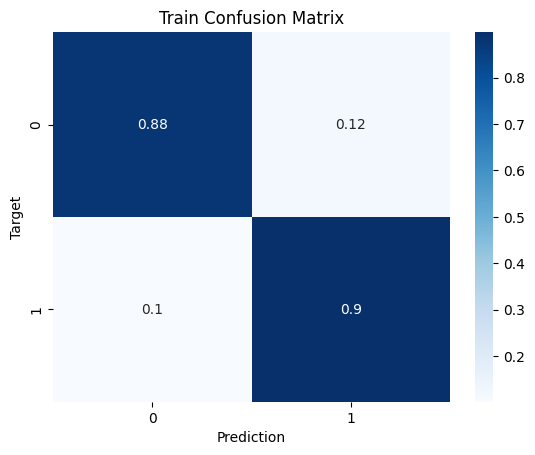

array([0, 1, 0, ..., 0, 0, 0])

In [26]:
predict_and_plot_roc_auc(final_clf, X_train, y_train, "Train")

Area under ROC score on Validation dataset: 0.85839564%


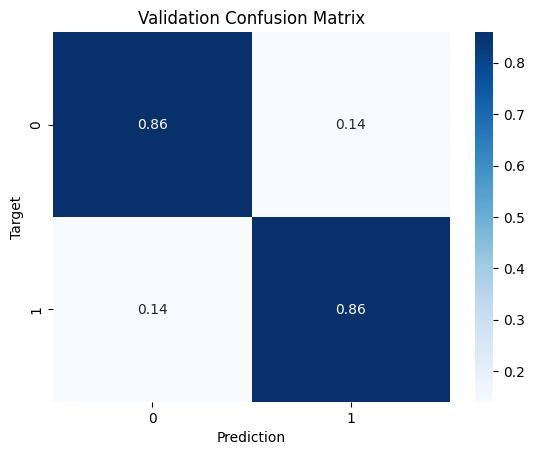

array([1, 0, 0, ..., 0, 0, 0])

In [27]:
predict_and_plot_roc_auc(final_clf, X_val, y_val, "Validation")

In [53]:
raw_new_df = pd.read_csv('kaggle/test.csv')
raw_new_df['preds'] = best_clf.predict_proba(X_test)[:, 1]

In [54]:
raw_new_df[['id', 'preds']].to_csv('kaggle/submission_xgb_0csv', index=False)

Висновок: отже, для передбачення в каглі, модель показала не найвищі показники, лише 0.93361, що на даний момент не є найкращим рішенням. Спробуємо поєднати логістичну регресію та xgboost classifier для отримання кращого результату. Доцільно спробувати збільшити регуляризацію, так як різниця між AUROC для train та validation є досить пристойною як для перформансу моделі. Далі буде...